# 画图

In [198]:
%matplotlib notebook
import imp, time
from collections import Counter, OrderedDict, defaultdict, deque, namedtuple

import matplotlib.pyplot as plt
import numpy as np, sympy as sy
from sklearn.cluster import KMeans
from scipy import constants as const
from scipy.fftpack import fft, hilbert, ifft
from scipy.optimize import curve_fit
from scipy.optimize import least_squares as ls
from sympy import diff, symbols
import pandas as pd
import qulab.optimize
from qulab.storage import connect
from qulab.storage.schema import Record, base
from qulab.storage.utils import save

op = imp.reload(qulab.optimize)
connect.connect()

In [2]:
def read(title=None,which=0):
    
    if title is None:
        x = Record.objects.order_by('-finished_time')[which]
    else:
        x = Record.objects(title=title).order_by('-finished_time')[which]
    tags, comment, name = x['tags'], x['comment'], x['title']
    data, ID = base.from_pickle(x.datafield), x.id
    return data, ID, comment, tags, name

In [181]:
x = Record.objects(title='S21').order_by('-finished_time')[9]
x

Record(title=S21, finished_time=2020-05-01 12:06:52.080190, tags=['q1'])

In [134]:
x = Record.objects
x

[Record(title=test, finished_time=2019-08-27 14:16:41.646491, tags=[]), Record(title=test, finished_time=2019-08-27 14:17:00.702043, tags=[]), Record(title=S21, finished_time=2019-08-28 16:58:17.810263, tags=['test']), Record(title=S21, finished_time=2019-08-28 17:02:13.496972, tags=['test']), Record(title=S21, finished_time=2019-08-28 18:07:15.241111, tags=['test']), Record(title=S21, finished_time=2019-08-28 18:16:55.605169, tags=['test']), Record(title=S21, finished_time=2019-08-28 18:19:54.707935, tags=['test']), Record(title=S21, finished_time=2019-08-28 18:20:49.434267, tags=['test']), Record(title=S21, finished_time=2019-08-28 18:24:37.873720, tags=['test']), Record(title=S21, finished_time=2019-08-28 18:29:05.948381, tags=['test']), Record(title=S21, finished_time=2019-08-28 18:29:50.123760, tags=['test']), Record(title=S21, finished_time=2019-08-28 18:30:52.540638, tags=['test']), Record(title=S21, finished_time=2019-08-28 18:35:24.175272, tags=['test']), Record(title=S21, fin

In [3]:
def write(phase=None,addr='mongodb',height=2,title=None,which=0,peak=110):
    if addr == 'mongodb':
        data, ID, comment, tags, name = read(title=title,which=which)
    else:
        d = np.load(addr)
        data, tags = (d['row'],d['col'],d['s']), d['tags']

    if len(data) == 2:
        num = len(data[0].T)
        if phase == 'phase': 
            fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,height*num))
            fig.subplots_adjust(top=0.9,bottom=0.1,hspace=0.5)
            v = []
            for i in range(num): 
                f, s = data[0][:,i],data[1][:,i]
                f = f / 1e9 if f[0] / 1e9 > 1 else f
                v.append((f,s))
                if num != 1:
                    
                    axes[i][0].plot(f,abs(s))
                    axes[i][1].plot(f,np.angle(s))
                else:
                    axes[0].plot(f,abs(s))
                    axes[1].plot(f,np.angle(s))
        else:
            n = num // 2 + num % 2
            fig, axes = plt.subplots(ncols=2,nrows=n,figsize=(9,height*n))
            fig.subplots_adjust(top=0.9,bottom=0.1,hspace=0.5)
            v = []
            for i in range(num): 
                f, s = data[0][:,i],data[1][:,i]
                f = f / 1e9 if f[0] / 1e9 > 1 else f
                v.append((f,s))
                if n != 1:
                    axes[i//2][i%2].plot(f,abs(s))
                    #axes[i//2][i%2].set_title(name)
                else:
                    axes[i].plot(f,abs(s))
                    if addr == 'mongodb':
                        axes[i].set_title(name)
        return v,num,tags
    if len(data) == 3 :
        
        num = len(data[0].T)
        if phase == 'phase': 
            n = num // 2 + num % 2
            fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,height*num))
            fig.subplots_adjust(top=0.9,bottom=0.1,hspace=0.5)
            v = []
            for i in range(num): 
                cols, rows, s= data[0][:,i], data[1][0,:], data[2][:,:,i]
                rows = rows / 1e9 if rows[0] / 1e9 > 1 else rows 
                cols = cols / 1e9 if cols[0] / 1e9 > 1 else cols 
                v.append((cols,rows,s))
                extent = [min(rows),max(rows),min(cols),max(cols)]
                if n != 1:
                    axes[i//2][i%2].imshow(abs(s),extent=extent,aspect='auto',origin='lower',interpolation='nearest')
                    #axes[i][1].imshow(np.angle(s),extent=extent,aspect='auto',origin='lower',interpolation='nearest')
                else:
                    #axes[0].imshow(abs(s),extent=extent,aspect='auto',origin='lower',interpolation='nearest')
                    axes[i].imshow(np.angle(s),extent=extent,aspect='auto',origin='lower',interpolation='nearest')
        else:
            n = num // 2 + num % 2
            fig, axes = plt.subplots(ncols=2,nrows=n,figsize=(9,height*n))
            fig.subplots_adjust(top=0.9,bottom=0.1,hspace=0.5)
            v = []
            for i in range(num): 
                cols, rows, s= data[0][:,i], data[1][0][:,i], data[2][:,:,i]
                rows = rows / 1e9 if rows[0] / 1e9 > 1 else rows 
                cols = cols / 1e9 if cols[0] / 1e9 > 1 else cols 
                s[np.abs(s) > peak] = s[np.abs(s)==np.min(np.abs(s))]
                v.append((cols,rows,s))
                extent = [min(rows),max(rows),min(cols),max(cols)]
                
                if n != 1:
                    axes[i//2][i%2].imshow(abs(s),extent=extent,aspect='auto',origin='lower',interpolation='nearest')
                    axes[i//2][i%2].set_title(tags[0])
                   
                else:
                    axes[i].imshow(np.abs(s),extent=extent,aspect='auto',origin='lower',interpolation='nearest',animated=True)
                    axes[i].set_title(tags[0])
        return v,num,tags

# qubit工作点

In [264]:

atributte = ['q_name','inst','T_bias','specfunc','bias','zpulse','f_lo','delta','f_ex','delta_ex',\
             'power_ex','power_rabi','pi_len','T1','state']
qubit = namedtuple('qubit',atributte,defaults=[None]*len(atributte))


## 保存qubit工作点

In [267]:
qstate = []
def tuple2dict(q):
    for i in q:
        qstate.append(i._asdict())
    return qstate

bit = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
filepath = save('QubitState','qubitstate',state = tuple2dict(bit),base_path=r'D:\skzhao\file_name')
with open(r'D:\skzhao\file_name\file_name.txt', mode='a') as filename:
    filename.write(str(filepath))
    filename.write('\n')
print(filepath)

D:\skzhao\file_name\2020\0503\QubitState\qubitstate_20200503221244.npz


In [220]:
q10 = q10._replace(inst={'dc': 'dc10', 'z_awg': 'awg131', 'z_ch': 8, 'ex_awg': 'awg132', 'ex_ch': [5, 6], 'ex_lo': 'psg_ex3', 'com': 'com6'})

## 提取qubit工作点

In [265]:
fl = np.loadtxt(r'D:\skzhao\file_name\file_name.txt',dtype='str')
f = str(fl[-1])
data = np.load(f,allow_pickle=True)
def dict2tuple(q):
    bit = []
    for i,k in enumerate(q):
        attr = []
        for j in atributte:
            if j in k:
                attr.append(k[j])
            else:
                attr.append(None)
        globals()['q%d'%(i+1)] = qubit(*attr)

dict2tuple(data['state'])
print(f)

D:\skzhao\file_name\2020\0503\QubitState\qubitstate_20200503163045.npz


# 查看图形

<IPython.core.display.Javascript object>


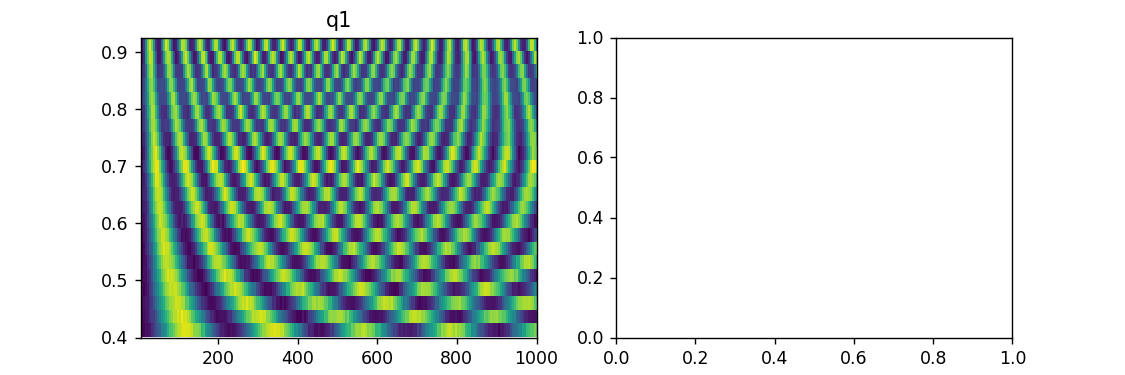

In [241]:
value,num,tags = write(height=3,which=0,peak=1120)

In [9]:
x,y = value[0][0],value[0][1]
x, y = x[30:141], y[30:141]
def err(paras,x,y):
    a, b, c, d, e = paras
    return a*np.exp(b*x) + c*np.exp(d*x) + e

<IPython.core.display.Javascript object>


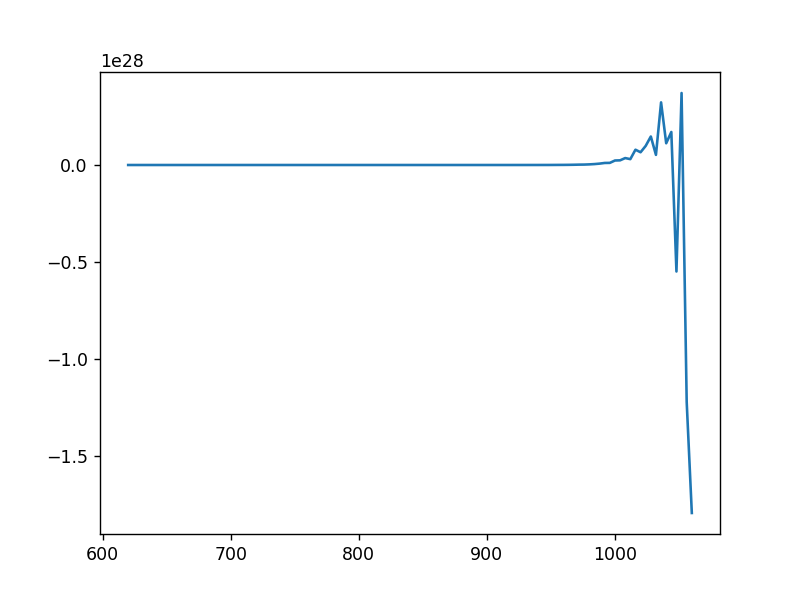

In [11]:
res = ls(err,[0.1,0.1,0.1,0.1,0.1],args=(x,np.abs(y)))
a, b, c, d, e = res.x
z = a*np.exp(b*x) + c*np.exp(d*x) + e
plt.figure()
plt.plot(x,z)
plt.show()

# RB

7


<IPython.core.display.Javascript object>


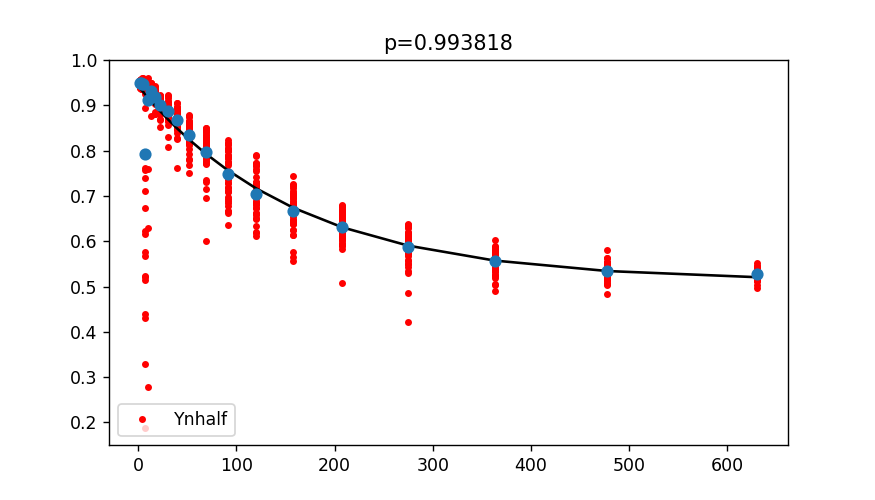

In [119]:
data, ID, comment, tags, name = read(title='RB_waveform',which=0)
print(tags[1])
n, pop = data[0][:,0],data[1]
x = np.meshgrid(range(np.shape(pop)[1]),n)[1]
plt.figure(figsize=(7,4))
x = np.meshgrid(range(np.shape(pop)[1]),n)[1]
plt.plot(x.flatten(),pop.flatten(),'r.',label='Ynhalf')
plt.legend(loc='lower left')
x, y = n, np.mean(pop,axis=1)
A,B,p = op.RB_Fit().fitRB(x,y)
z = A*p**x+B
plt.plot(x,z,'k')
plt.plot(x,y,'o')
plt.title('p=%f'%p)
plt.show()

In [120]:
Pref, Pgate, d = 0.995855, 0.993818, 2**(1)
Rgate = (1-Pgate/Pref)*(1-1/d)
Rgate

0.0010227392542087044

# pi脉冲优化

<IPython.core.display.Javascript object>


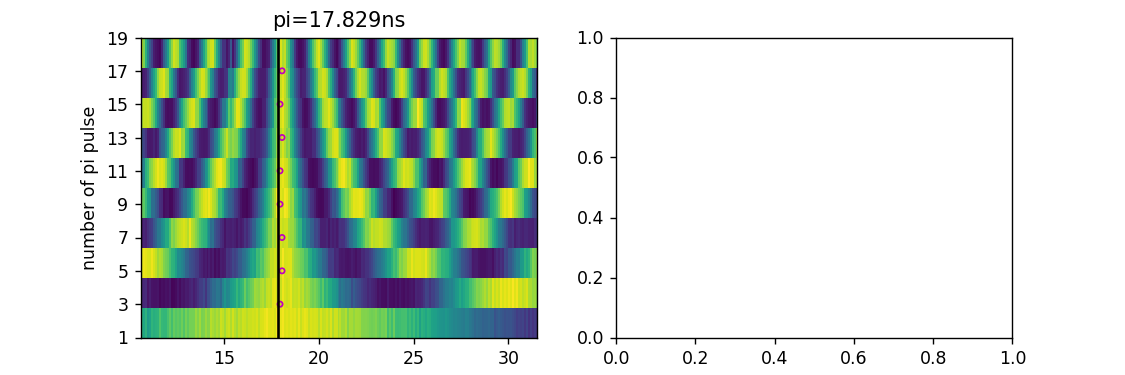

In [231]:
value,num,tags = write(title='pipulseOpt',height=3,which=0,peak=1120)

In [232]:
x, y, s = value[0][0],value[0][1], np.abs(value[0][2])
index = y[np.argmax(np.abs(s),axis=1)[0]]
y = np.array([op.RowToRipe().firstMax(y,z,num=index,peakpercent=0.9,insitu=True) for z in s])
fig = plt.gcf()
ax = plt.getp(fig,'axes')
ax[0].set_xlabel('time / ns')
ax[0].set_yticks(x)
ax[0].set_ylabel('number of pi pulse')
ax[0].scatter(y[1:-1],x[1:-1],marker='.',c='',edgecolors='m')
ax[0].vlines(np.mean(y),np.max(x),np.min(x))
ax[0].set_title('pi=%.3fns'%np.mean(y))
plt.show()

# Crosstalk矩阵

In [41]:
z_crosstalk = np.ones((10,10))

<IPython.core.display.Javascript object>


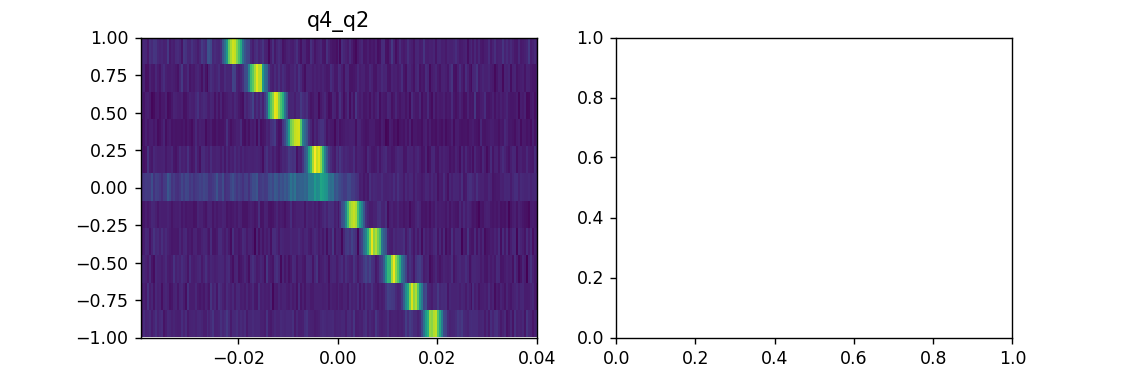

In [45]:
value,num,tags, fig, axes = write(height=3,title='crosstalkSpec',which=5,peak=1120)

In [ ]:
'q6-q3','q4_q7','q4-q6','q4-q5'

In [44]:
target = 1
v, f, s = value[target-1][0], value[target-1][1], value[target-1][2]
peak = (np.max(np.abs(s))+np.min(np.abs(s))) / 3
v, f, res = op.Crosstalk_Fit(peak=peak).fitCrosstalk(v,f,s,classify=False)
z = res[0]*f + res[1]
row, col = eval(tags[0][1])-1, eval(tags[0][-1])-1
z_crosstalk[row,col] = -1/res[0]
fig = plt.gcf()
ax = plt.getp(fig,'axes')
ax[target-1].scatter(f[1:-1],v[1:-1],marker='.',c='',edgecolors='m')
ax[target-1].plot(f[1:-1],z[1:-1],'r--')
plt.show()

In [174]:
qname = ['q2','q3','q4','q5']
pd.DataFrame(z_crosstalk.T[1:5,1:5],columns=qname,index=qname)

,q2,q3,q4,q5
q2,1.000000,-0.011626,-0.003775,-0.007910
q3,0.019994,1.000000,-0.017023,-0.007725
q4,0.020027,0.021286,1.000000,-0.022010
q5,0.016164,0.014805,0.013947,1.000000


In [116]:
old = np.array([[ 1.        , -0.00614072,  0.00237171,  0.00339285,  0.01229189],
       [ 0.01965284,  1.        , -0.01015246, -0.00295805, -0.00609832],
       [ 0.01144612,  0.02177006,  1.        , -0.01671896, -0.00728347],
       [ 0.01140976,  0.02193547,  0.02581161,  1.        , -0.01872843],
       [ 0.00925843,  0.01711204,  0.01496927,  0.01558848,  1.        ]])

In [188]:
qname = ['q2','q3','q4','q5']
pd.DataFrame(old[1:5,1:5],columns=qname,index=qname)

,q2,q3,q4,q5
q2,1.000000,-0.010152,-0.002958,-0.006098
q3,0.021770,1.000000,-0.016719,-0.007283
q4,0.021935,0.025812,1.000000,-0.018728
q5,0.017112,0.014969,0.015588,1.000000


In [189]:
z = z_crosstalk.T[1:5,1:5] - old[1:5,1:5]
qname = ['q2','q3','q4','q5']
pd.DataFrame(z,columns=qname,index=qname)

,q2,q3,q4,q5
q2,0.000000,-0.001474,-0.000817,-0.001812
q3,-0.001776,0.000000,-0.000304,-0.000442
q4,-0.001909,-0.004526,0.000000,-0.003282
q5,-0.000948,-0.000164,-0.001641,0.000000


In [176]:
save('crosstalk_cali','xue_crosstalk_q2_5',mat=z_crosstalk.T)

WindowsPath('D:/QuLabData/2020/0401/crosstalk_cali/xue_crosstalk_q2_5_20200401211425.npz')

# 拟合二维谱

<IPython.core.display.Javascript object>


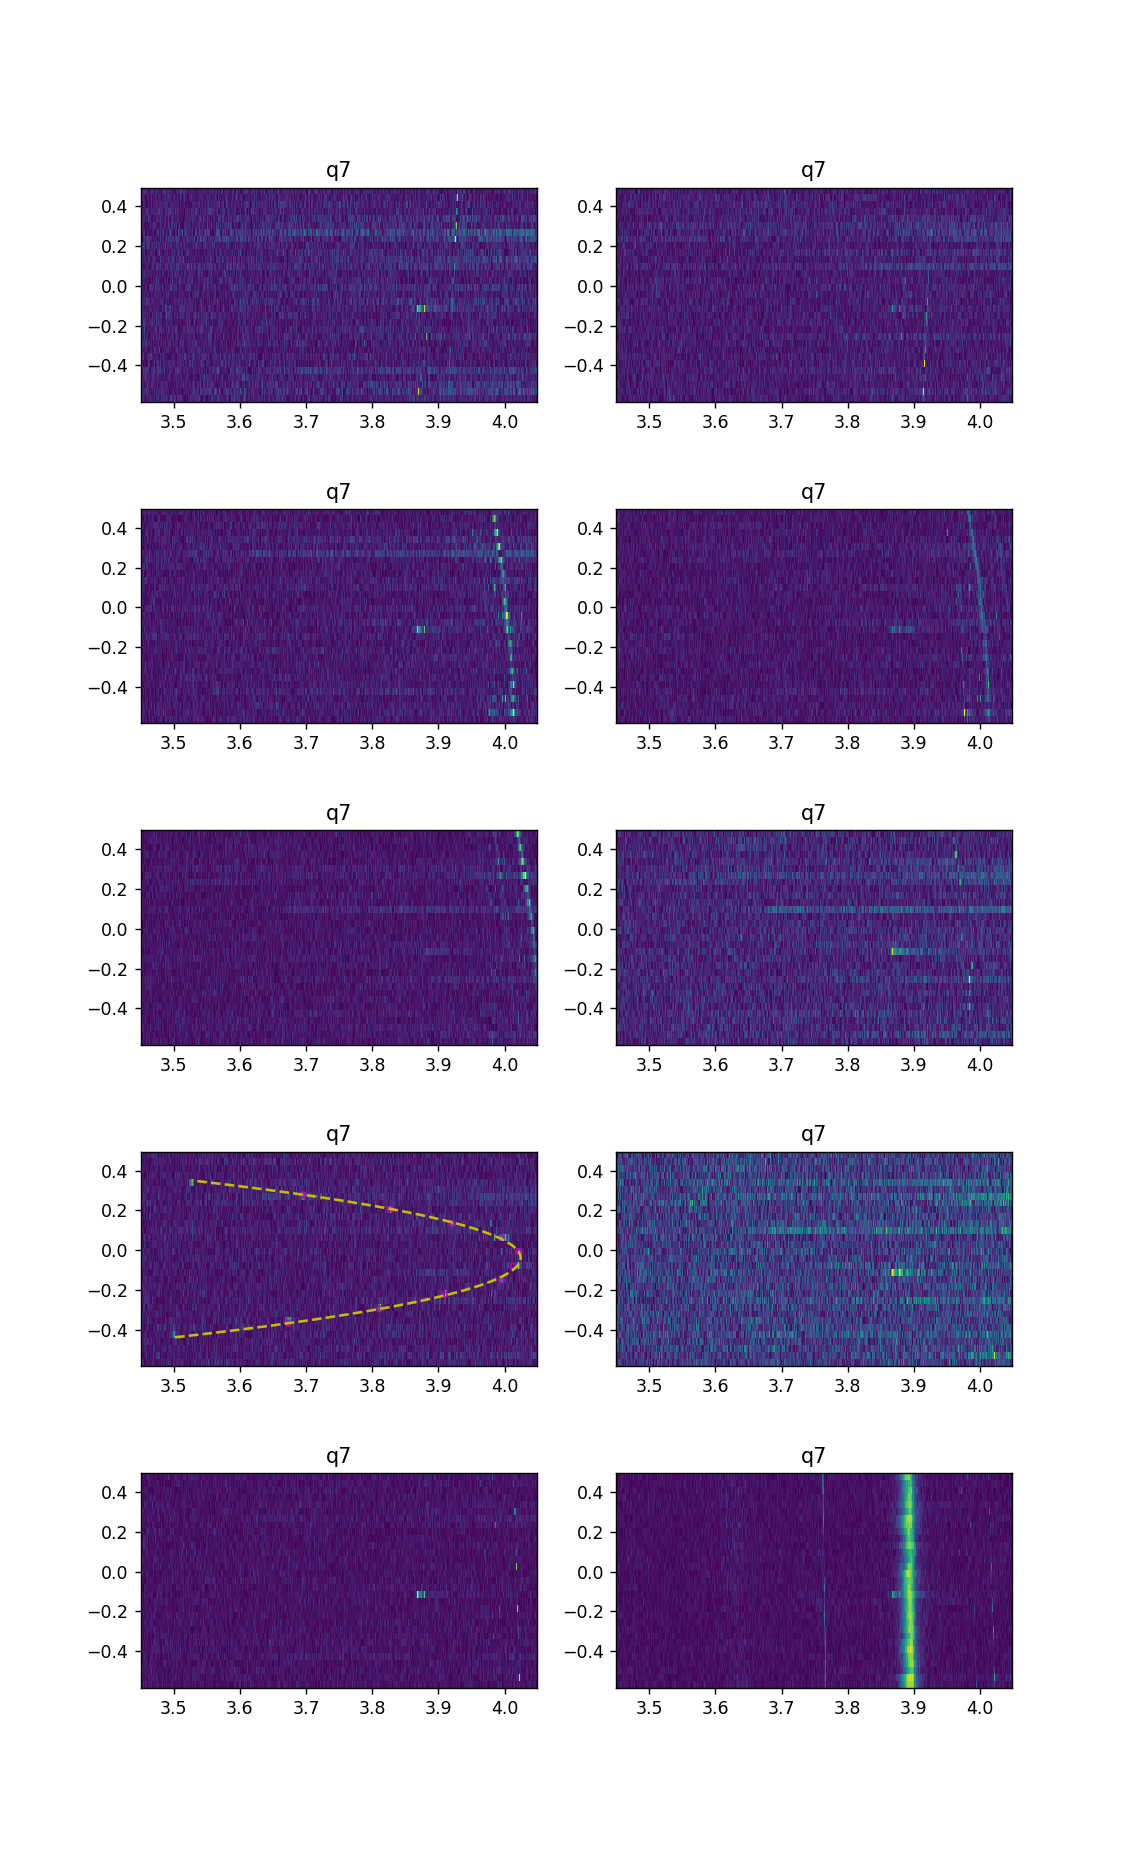

In [199]:
value,num,tags = write(height=3,title='spec2d',which=30,peak=1000)

In [200]:
target = 7
v, f, s = value[target-1][0], value[target-1][1], value[target-1][2]
peak = (np.max(np.abs(s))+np.min(np.abs(s))) / 2
f,v,A, C, W, phi = op.Spec2d_Fit(peak=peak).fitSpec2d(v,f,s,classify=False)
v1 = np.linspace(min(v),max(v),1001)
# z = A*np.cos(2*np.pi*W*v1+phi)+C
z = np.sqrt(A*np.abs(np.cos(W*v1+phi))) + C
fig = plt.gcf()
ax = plt.getp(fig,'axes')
ax[target-1].scatter(f[1:-1],v[1:-1],marker='.',c='',edgecolors='m')
ax[target-1].plot(z[1:-1],v1[1:-1],'y--')
plt.show()

0.5209999999999422 3.8239999999999585 1.160631383472609 5.442600295689944


In [201]:
C

-1.4321908838476145

<IPython.core.display.Javascript object>


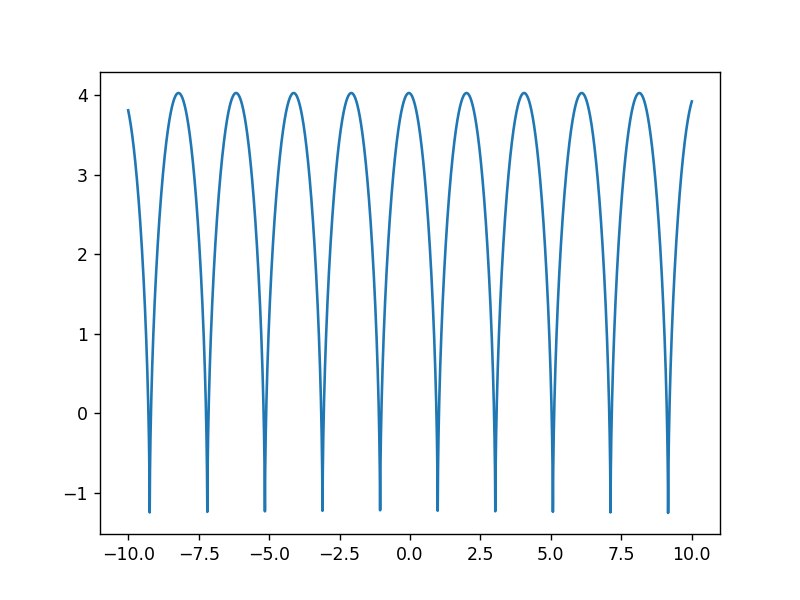

In [202]:
plt.figure()
v1 = np.linspace(-10,10,10001)
z = np.sqrt(A*np.abs(np.cos(W*v1+phi))) + C
plt.plot(v1,z)
plt.show()

In [30]:
x = sy.Symbol('x',real=True)
y = A*sy.cos(2*sy.pi*W*x+phi)+C

In [34]:
q6 = q6._replace(specfunc=y)

In [36]:
q6.specfunc.evalf(subs={x:0.})

3.66251546755387

In [82]:
q4

qubit(q_name='q4', inst={'dc': 'dc11', 'z_awg': 'awg131', 'z_ch': 4, 'ex_awg': 'awg132', 'ex_ch': [7, 8], 'ex_lo': 'psg_ex2', 'com': 'com8'}, T_bias=[1.753, 0.176], specfunc=-199.359302124614*cos(0.0594068374593189*pi*x + 3.10601583645447) - 195.359697320355, bias=-0.2, zpulse=None, f_lo=array([6.54368e+09]), delta=array([50000000.]), f_ex=array([3.77395348e+09]), delta_ex=array([0]), power_ex=30, pi_len=19.0, T1=26511.572081147293)

# 拟合调制曲线找周期

In [245]:
n = 10
Tlist = {}
matrix_cross = np.zeros((n,n)) #收集crosstalk矩阵元
matrix_phi = np.zeros((n,n))

<IPython.core.display.Javascript object>


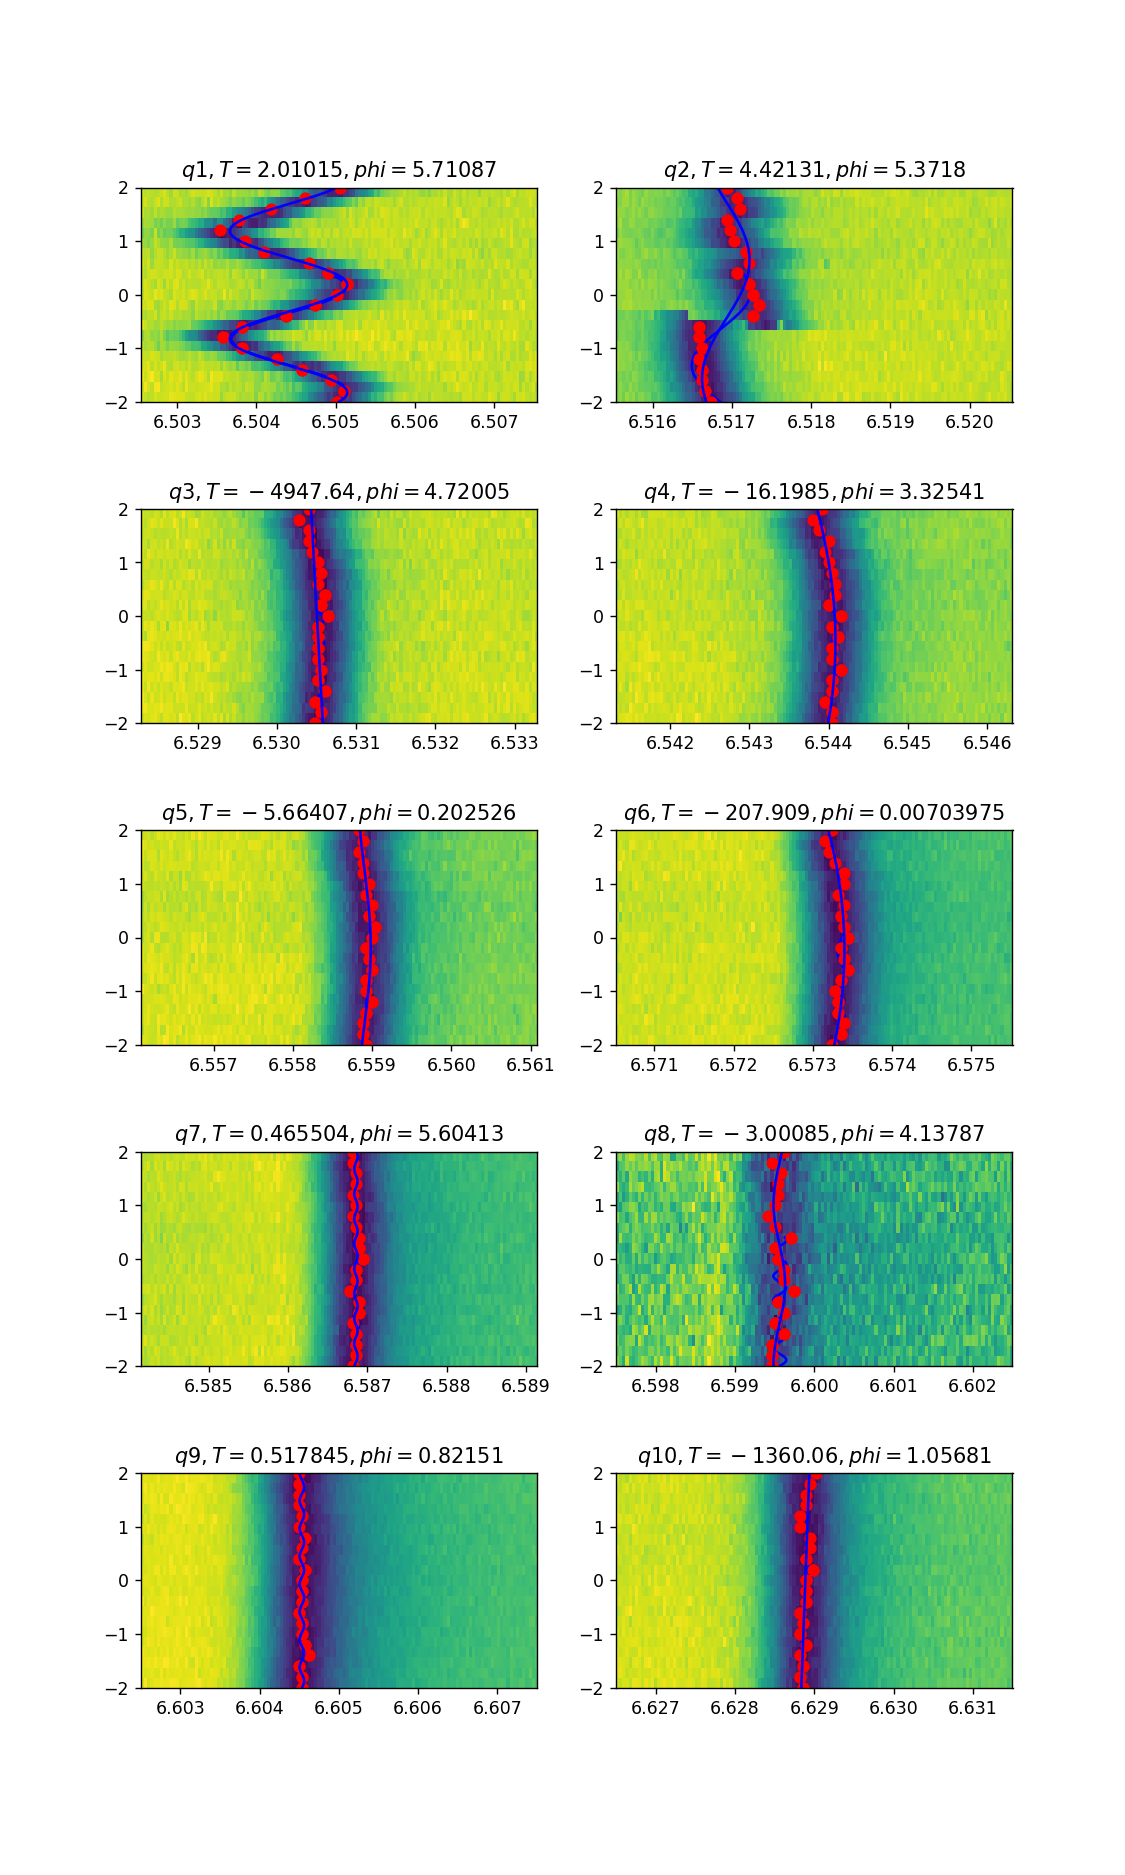

In [259]:
value,num,tags = write(height=3,title='S21vsFlux',which=4,peak=1000) #S21vsFlux_awgoffset

In [262]:
n_target = eval(tags[0][1:])
mat = fit_cos(tag='q_%d'%n_target)
matrix_cross[:,n_target-1] = np.array(mat)[:,0]
matrix_phi[:,n_target-1] = np.array(mat)[:,1]
Tlist

0.0015999999999998238 6.504433333333333 0.47619047619047616 7.179358725651319
0.0007599999999996498 6.516932380952381 0.23809523809523808 4.818706518736985
0.0003599999999996939 6.530504761904762 0.23809523809523808 4.631626751510944
0.0003599999999996939 6.5440209523809525 0.23809523809523808 4.509854559436101
0.00020000000000042206 6.558929523809523 0.23809523809523808 4.610426392835186
0.000280000000000058 6.5733371428571425 0.23809523809523808 4.917094499186223
0.00016000000000016001 6.58685619047619 0.23809523809523808 4.7909543438783135
0.00031999999999943185 6.599549523809524 0.23809523809523808 4.846335432519602
0.00011999999999989797 6.604534285714286 1.9047619047619047 25.45910329152412
0.00019999999999953388 6.628886666666667 0.47619047619047616 7.688513923043734


{'q5': [1.797, 0.048],
 'q4': [1.756, 0.056],
 'q3': [1.754, 0.036],
 'q2': [1.835, 0.066],
 'q1': [2.01, 0.184]}

In [261]:
def fit_cos(tag):
    mat = []
    At = 0
    for i in range(len(value)):
        volt, freq, s = value[i]
#         volt, s = volt[:13], s[:13,:]
        x, y = op.RowToRipe().manipulation(volt,freq,s)
        A, C, W, phi = op.Cos_Fit().fitCos(x,y)
        T = 1 / W
        fig = plt.gcf() 
        axes = plt.getp(fig,'axes')
        axes[i].plot(y,x,'ro')
        x1 = np.linspace(min(volt),max(volt),1001)
        y1 = A*np.cos(2*np.pi/T*x1+phi)
        axes[i].plot(y1+C,x1,'b-')
        #if i != int(tag[2:]) - 1:
        t = symbols("t")
        z = A*sy.cos(2*np.pi/T*t+phi)+C
        z_diff = diff(z,t)
        if z_diff.evalf(subs = {t:0}) < 0:
            T *= -1
            if phi<0:
                phi *= -1
        phi = phi % (2*np.pi)
        mat.append((1/T,phi))
        if i == int(tag[2:]) - 1:
            bias0 = op.RowToRipe().firstMax(x1,y1,num=0)
            Tlist[tags[0]] = [round(np.abs(T),3),bias0]
        axes[i].set_title(r'$ q%d,T = %g,phi=%g $' %(i+1,T,phi))
    return mat
        

In [266]:
bit = [q1,q2,q3,q4,q5]
for i, j in enumerate(bit):
    globals()['q%d'%(i+1)] = j._replace(T_bias=Tlist['q%d'%(i+1)])

# 拟合T1

<IPython.core.display.Javascript object>


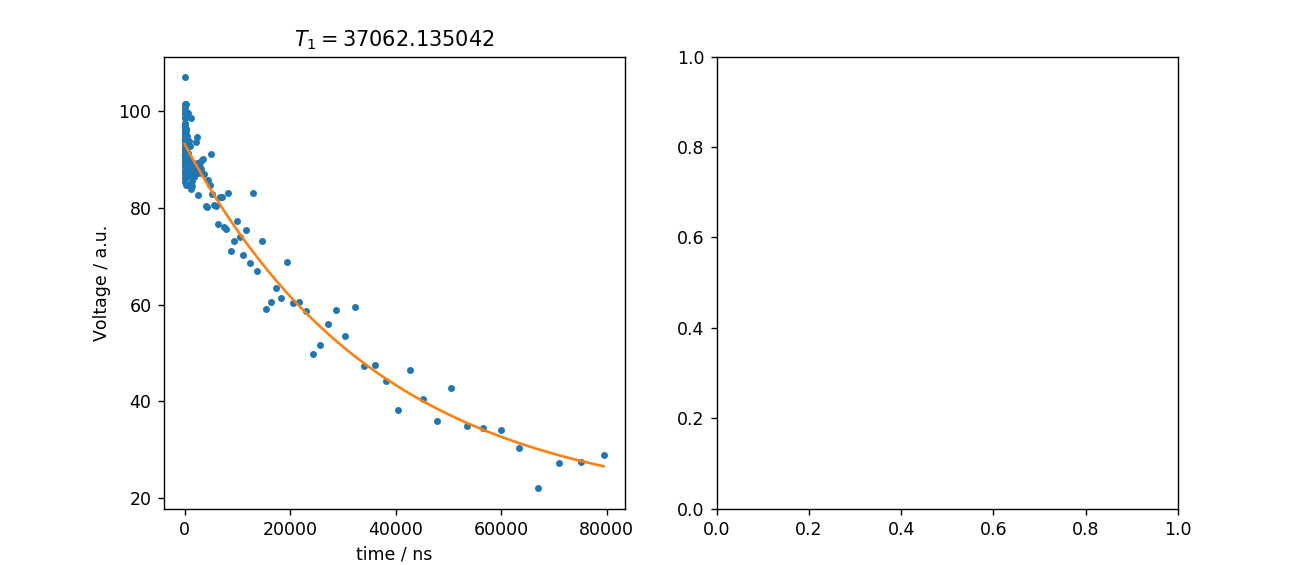

In [87]:
value,num,tags = write(height=4,title='T1',which=0)

In [88]:
x, y = value[0][0], value[0][1]
A, B, T1 = op.Exp_Fit().fitExp(x,np.abs(y))
z = A * np.exp(-x/T1) + B
fig = plt.gcf()
ax = plt.getp(fig,'axes')
ax[0].plot(x,z)
ax[0].set_title('$T_{1}=%f$'%T1)
ax[i].set_xlabel('time / ns')
ax[i].set_ylabel('Voltage / a.u.')
plt.show()

# 拟合Rabi

<IPython.core.display.Javascript object>


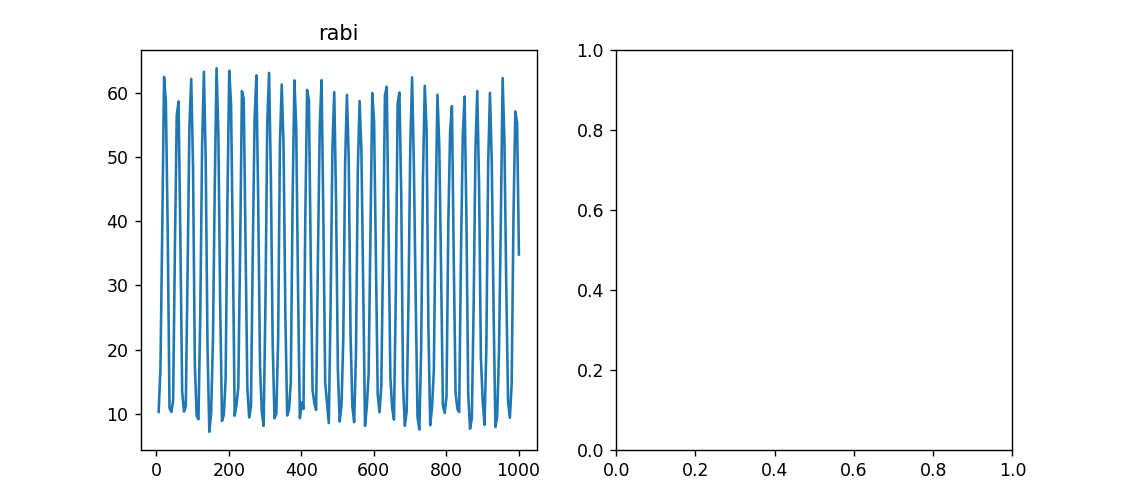

In [272]:
value,num,tags = write(height=4,title='rabi',which=0)  

In [271]:
fig = plt.gcf()
ax = plt.getp(fig,'axes')
for i in range(num):
    x, y  = value[i][0], value[i][1]
    A,B,T1,w,phi,out = op.Rabi_Fit(envelopemethod='hilbert').fitRabi(np.abs(x),np.abs(y))
    z = A*np.exp(-x/T1)*np.cos(2*np.pi*w*x+phi) + B
#     env = out[0]*np.exp(-x/out[2]) + out[1]
    env = A*np.exp(-x/T1) + B
    ax[i].plot(x,z)
#     ax[i].plot(x,out[3])
    ax[i].plot(x,env)
    ax[i].set_title('$T_{1}=%f,period=%f$'%(T1,1/w/2))
    ax[i].set_xlabel('time / ns')
    ax[i].set_ylabel('Voltage / a.u.')
plt.show()

(29.33885647815767, 32.02821839550802, 20000, 0.028000000000000004, 1.5707963267948966)


d:\qulab\qulab\optimize.py:282: RuntimeWarning: overflow encountered in multiply
  return np.sum((A*np.exp(-x/T1)*np.cos(2*np.pi*w*x+phi) + B - y)**2)


# 拟合Ramsey及SpinEcho

<IPython.core.display.Javascript object>


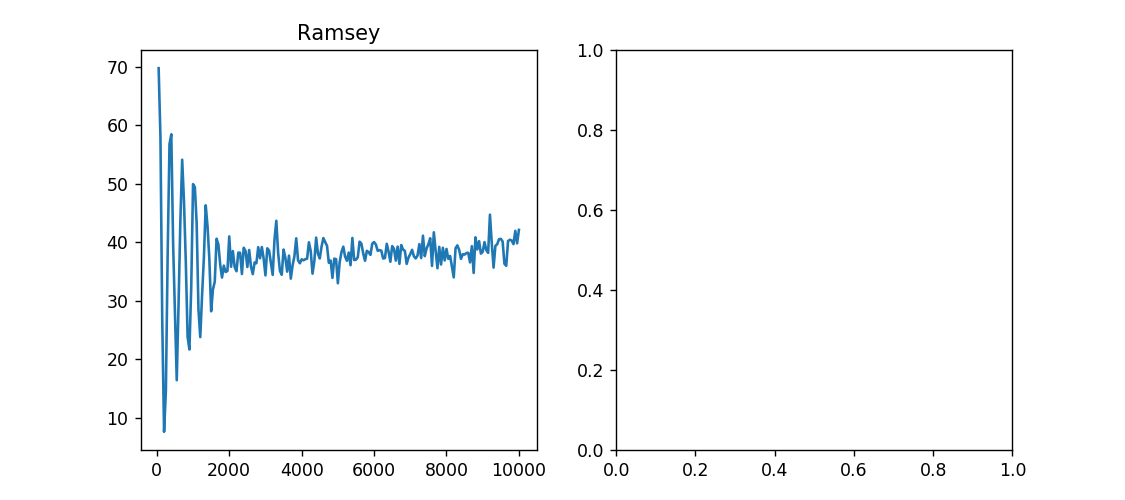

In [274]:
value,num,tags = write(height=4,title='Ramsey',which=9)

In [172]:
fig = plt.gcf()
ax = plt.getp(fig,'axes')
for i in range(num):
    x, y  = value[i][0], value[i][1]
    sample = (np.max(x) - np.min(x))/(len(x) - 1)
    yt  = np.fft.fftshift(np.fft.fftfreq(len(y))) / sample
    amp = np.fft.fftshift(np.fft.fft(y))
    A,B,T1,T2,w,phi,out = op.T2_Fit(funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
    z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
    z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
    env = out[0]*np.exp(-(x/out[3])**2-x/out[2]/2)+out[1]
    ax[i].plot(x,z)
    ax[i].plot(x,z_env)
#     ax[i].plot(x,out[-1])
    #ax[i].set_title('$T_{1}=%f,T_{2}=%f,w=%f$'%(T1,T2,w*1e3))
    ax[i].set_title('$T_{2}=%f$'%T2)
    ax[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
    ax[i].set_xlabel('time / ns')
    ax[i].set_ylabel('Voltage / a.u.')
plt.show()

(35.89198855141906, 38.143329452183444, 35000, 1628.0, 0.0024, 0)
